In [1]:
from src.optimal import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import timeit
import random
from statistics import mean, variance
from math import floor, ceil

In [2]:
# Seed random for repeatability
seed = 100
random.seed(seed)
np.random.seed(seed)
# Set max number of param variations to run
variations = 500
# number of timeit executions per repeat
number = 100
# number of repeats
repeats = 5

In [3]:
k_lim = (1, 1000)
s_max_lim = (0, 1000)
c_max = 20
n_lim_fcn = lambda k, s_max_avg: (1, ceil(k * s_max_avg))
s_min_lim_fcn = lambda n, s_max_lim: (0, min(n // 8, s_max_lim[1] * 0.5))
beta_lim_fcn = lambda k: (0, k // 8)

In [4]:
def make_random_input_set():
    # workers
    k = random.randint(k_lim[0], k_lim[1])
    s_max = [random.randint(s_max_lim[0], s_max_lim[1]) for _ in range(k)]
    s_max_avg = mean(s_max)
    c = [round(random.random() * c_max, 2) for _ in range(k)]
    # data set
    n_lim = n_lim_fcn(k, s_max_avg)
    n = random.randint(n_lim[0], n_lim[1])
    # params
    s_min_lim = s_min_lim_fcn(n, s_max_lim)
    s_min = random.randint(s_min_lim[0], s_min_lim[1])
    beta_lim = beta_lim_fcn(k)
    beta = random.randint(beta_lim[0], beta_lim[1])

    input_set = InputSet(n, beta, s_min, k, s_max, c)
    return input_set


def make_workers(input_set: InputSet):
    workers = [Worker(input_set.s_max[i], input_set.c[i], i) for i in range(input_set.k)]
    return workers

def make_data_set(input_set: InputSet):
    data_set = [i for i in range(input_set.n)]
    return data_set

In [5]:
times: List[List[float]] = [None]*variations
input_sets = []
infeasible = set()

stmt = '''
try:
    assign_work(workers, data_set, input_set.beta, input_set.s_min)
except (InsufficientWorkersError, InsufficientCapacityError, InsufficientDataError, InfeasibleWorkerCapacityError, AssignmentError, ValueError) as e:
    infeasible.add(i)
    pass
'''
for i in range(variations):
    input_set = make_random_input_set()
    workers = make_workers(input_set)
    data_set = make_data_set(input_set)
    input_sets.append(input_set)
    time = timeit.repeat(stmt=stmt, repeat=repeats, number=number, globals=globals())
    times[i] = time


In [6]:
feasible_input_sets = [x[1] for x in enumerate(input_sets) if not (x[0] in infeasible)]
k = [d.k for d in feasible_input_sets]
n = [d.n for d in feasible_input_sets]

feasible_times = [x[1] for x in enumerate(times) if not (x[0] in infeasible)]
avg_times = [mean(x) for x in feasible_times]
var_times = [variance(x) for x in feasible_times]

surface = np.array([k, n, avg_times])
surface.shape


(3, 426)

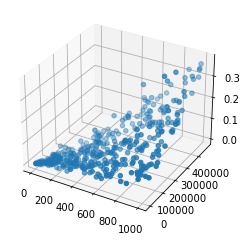

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(k, n, avg_times);

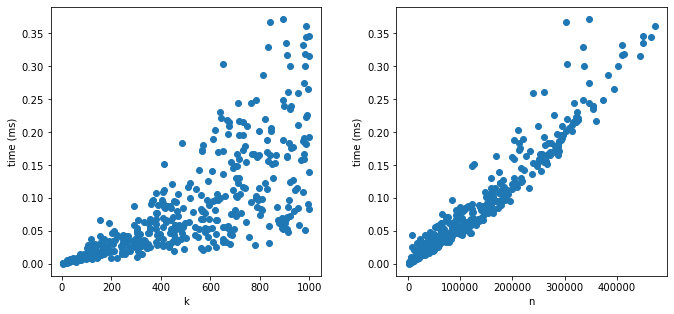

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(k, avg_times);  # k
ax1.set_xlabel("k")
ax1.set_ylabel("time (ms)")
ax2.scatter(n, avg_times);  # n
ax2.set_xlabel("n")
ax2.set_ylabel("time (ms)")
fig.tight_layout(pad=3.0)